# Set up coding env

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# You only need to run these cells once!
!pip install scanpy
!pip3 install igraph
!pip3 install leidenalg

# Load data

* wget is a command line tool that allows us to download files from the web
* putting a ! in front of a command allows us to directly access command line commands, using bash not python


In [ ]:
#download our rna seq dataset -- you only need to do this once!
!wget -O ./data.zip https://celltypes.brain-map.org/api/v2/well_known_file_download/738606142
! unzip ./data.zip -d .

### We will use pandas to load in our dataframe
* pandas is a great tool for manipulating large data frames
* by setting index_col = 0, we tell pandas that the first column of our csv should be the index of our dataframe
* the index operates as a label for each row, allowing easy access

In [2]:
#load data into dataframe
gene_mat = pd.read_csv('mouse_ACA_2018-10-04_exon-matrix.csv',index_col=0).T

### Visualise your data table
* this is always a good first step
* you can visually check that the data looks correct, e.g. we are working with count data so all data should be integers

In [3]:
#visualise your data table!
# viewing your dataframe is always a first step!!
# can we look for any errors, e.g. numbers that should exist
gene_mat.head()

,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,...,n-R5s134,n-R5s136,n-R5s138,n-R5s139,n-R5s141,n-R5s142,n-R5s143,n-R5s144,n-R5s146,n-R5s149
SM-DD44B_S81_E1-50,0,0,0,912,0,0,0,0,1030,639,...,0,0,0,0,0,0,0,0,0,0
SM-DD44B_S82_E1-50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SM-DD44B_S83_E1-50,0,0,0,1507,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SM-DD44B_S84_E1-50,0,0,344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SM-DD44B_S85_E1-50,0,0,143,103,140,0,0,0,308,58,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Print the dimensions of our data!
print(gene_mat.shape)

(5028, 45768)


# Filtering, and Normalising our data

### Filtering
* We want to reduce down the number of features in our dataset
* Doing so can help us to remove genes that do not add much relevant information
* This will help us with visualisation and inference later on
* an easy way to do this at first is to filter out genes that have low expression - low expression across all cells means they are not providing much information in defining celltypes
* another key step is to only retain genes that are highly variable - if genes are similar across all cells then they do not tell us anything about different celltypes

In [3]:
### Filter out cells (columns) with less than 10 total counts

#Create a boolean (True,False binary vector) that tells us which genes have fewer than 10 counts across all cells
sum_boolean = gene_mat.sum(axis=0) > 10

### Create a boolean that tells us which genes have 1std > 2 counts (i.e. approx 65% of the data lies within 2 counts of the mean)
std_boolean = gene_mat.std(axis=0) > 2

##COMPLETE##
#Filter our gene_mat with genes that are greater than 10 counts AND std 2
filtered_mat = gene_mat.loc[:,sum_boolean & std_boolean]

#print how many cells were removed
print(f"Removed {gene_mat.shape[1] - filtered_mat.shape[1]} cells")

Removed 27651 cells


### Normalising our count data
* normalising makes sure our data is in a comparable scale
* because the reaction inside each cell can take place with different efficiencies, the overall amplification of RNA can be different across cells
* directly comparing genes across cells might lead us to falsely conclude there are differences in gene levels when really it is just due to differenes in the amplification reaction
* therefore, we divide each gene by the sum of all counts for a cell - this ensures we are looking at relative gene expression, given the total amount of RNA in the cell
* we then multiple by a million to make the number in an easier to visualise range

In [4]:
#Compute CPM
# Step 1: Compute CPM
library_sizes = filtered_mat.sum(axis=1) # Total counts per cell
cpm = (filtered_mat.div(library_sizes, axis=0)) * 1e6  # Normalize to CPM
cpm

,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
SM-DD44B_S81_E1-50,0.000000,569.070992,0.000000,0.000000,0.000000,642.700791,398.724083,0.000000,0.000000,0.000000,...,0.000000,5433.005618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SM-DD44B_S82_E1-50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,687.149434,0.000000,864.384594,0.000000,633.397787,1.452747,0.000000,0.000000,0.000000
SM-DD44B_S83_E1-50,0.000000,1806.038424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,552.477580,0.000000,...,0.000000,3494.630421,0.000000,0.000000,0.000000,0.000000,0.000000,336.759653,0.000000,0.000000
SM-DD44B_S84_E1-50,386.494706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.006312,...,0.000000,5297.449247,0.000000,0.000000,0.000000,0.000000,0.000000,1.123531,0.000000,1.123531
SM-DD44B_S85_E1-50,78.134605,56.278771,76.495417,0.000000,0.000000,168.289918,31.690959,2.185583,195.063314,208.176814,...,0.000000,4414.878359,0.000000,7.103146,15.845479,150.258855,0.000000,0.000000,0.000000,83.598563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM-GE671_S236_E1-50,153.688396,98.259794,0.000000,7.558446,17.636373,60.467565,73.064975,60.467565,141.090986,0.000000,...,27.714301,6011.483798,0.000000,0.000000,27.714301,22.675337,0.000000,0.000000,80.623421,78.103939
SM-GE671_S237_E1-50,58.727953,182.709186,0.000000,4.350219,0.000000,76.128827,87.004374,63.078171,134.856780,4.350219,...,0.000000,7064.755181,0.000000,0.000000,0.000000,82.654155,13.050656,0.000000,4.350219,226.211373
SM-GE671_S238_E1-50,102.265921,99.831018,0.000000,7.304709,0.000000,9.739611,26.783932,38.958446,185.052618,19.479223,...,0.000000,6084.822276,0.000000,0.000000,7.304709,31.653737,21.914126,14.609417,0.000000,129.049852
SM-GE671_S239_E1-50,96.688218,56.751780,0.000000,2.101918,0.000000,184.968766,60.955616,96.688218,210.191779,6.305753,...,0.000000,4582.180782,10.509589,0.000000,0.000000,92.484383,8.407671,56.751780,54.649863,245.924381


### Log transforming the data
* genetics data is highly skewed, with most cells showing low cpm but some showing extremely high cpm
* this makes working with the data difficult as most of the data we are interested in has a very small range, whereas the majority of the range of the data is not being used
* A way to deal with this is taking the logarithm of the data, so that instead of dealing with CPMs we use the power that would give rise to a given CPM
* This works because distances between smaller powers are much smaller than distances between larger powers, so that the lower end of our data gets spread out relative to the higher end

The log-transformed CPM value is given by $X = \log_2 (CPM + 1)$.

We add the + 1 to deal with 0 CPMs, as you cannot have a log(0)


In [5]:
# Step 2: Log-transform CPM
log_cpm =  np.log1p(cpm)
log_cpm.head()

,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
SM-DD44B_S81_E1-50,0.000000,6.345761,0.000000,0.0,0.0,6.467234,5.990775,0.000000,0.000000,0.000000,...,0.0,8.600432,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
SM-DD44B_S82_E1-50,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,6.534006,0.0,6.763174,0.000000,6.452676,0.897209,0.000000,0.0,0.000000
SM-DD44B_S83_E1-50,0.000000,7.499445,0.000000,0.0,0.0,0.000000,0.000000,0.000000,6.316221,0.000000,...,0.0,8.159269,0.0,0.000000,0.000000,0.000000,0.000000,5.822335,0.0,0.000000
SM-DD44B_S84_E1-50,5.959702,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.645469,...,0.0,8.575169,0.0,0.000000,0.000000,0.000000,0.000000,0.753080,0.0,0.753080
SM-DD44B_S85_E1-50,4.371150,4.047930,4.350219,0.0,0.0,5.131613,3.487099,1.158635,5.278438,5.343180,...,0.0,8.392962,0.0,2.092252,2.824082,5.018993,0.000000,0.000000,0.0,4.437917


In [7]:
# Delete a couple of variables to free up space
del filtered_mat
del gene_mat

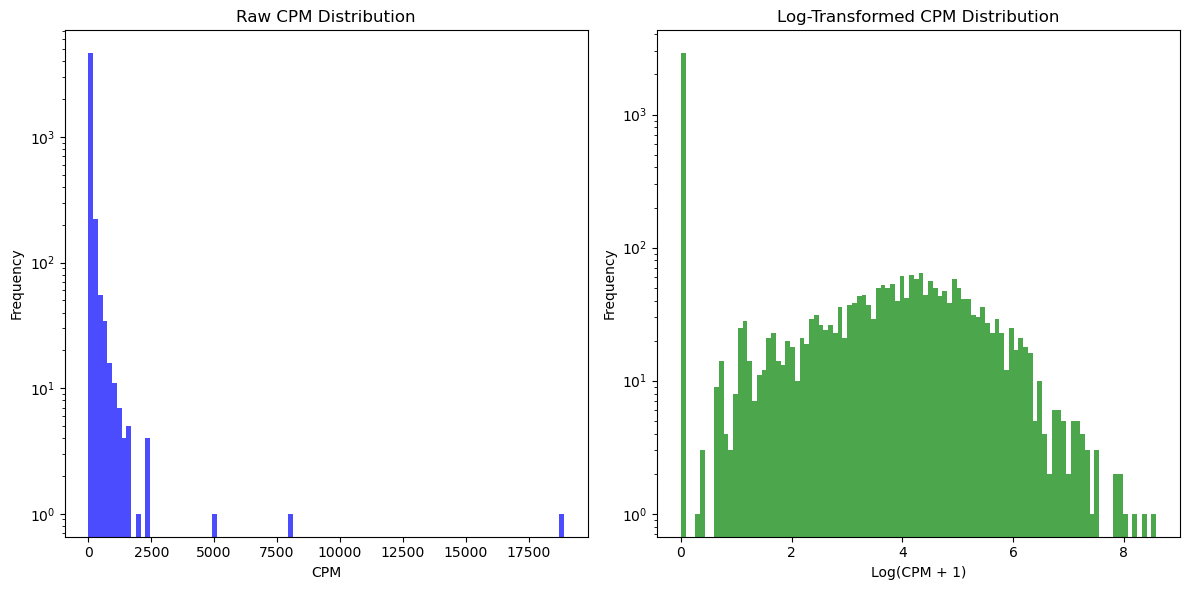

In [9]:
#Visualise effect of doing this

# Step 3: Visualization of Distributions, take random subset for memory

#Take a random subset for visualization (reduce RAM usage)
subset_size = 5000  # Adjust as needed for RAM constraints
cpm_sample = cpm.values.flatten()
log_cpm_sample = log_cpm.values.flatten()

# Randomly sample values
cpm_sample = np.random.choice(cpm_sample, subset_size, replace=False)
log_cpm_sample = np.random.choice(log_cpm_sample, subset_size, replace=False)

#Step 3: Visualization of Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram of raw CPM
axes[0].hist(cpm_sample, bins=100, color='blue', alpha=0.7)
axes[0].set_title("Raw CPM Distribution")
axes[0].set_xlabel("CPM")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale('log')

# Histogram of log-transformed CPM
axes[1].hist(log_cpm_sample, bins=100, color='green', alpha=0.7)
axes[1].set_title("Log-Transformed CPM Distribution")
axes[1].set_xlabel("Log(CPM + 1)")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale('log')  # Log scale for frequency

plt.tight_layout()
plt.show()


# Clustering and dimensionality reduction
* we use leiden clustering to try and automatically find groups of cells in our data that are similar to eachother
* here we use scanpy, a great package for handling scRNAseq data

In [10]:
# Convert log-transformed data into AnnData format
adata = sc.AnnData(log_cpm)  # Transpose so cells are observations (rows)

adata

AnnData object with n_obs × n_vars = 5028 × 18117

### Doing PCA as feature extraction
* Before we start clustering, it helps to reduce down the dimensionality of our feature space
* Here we make use of PCA, a linear dimensionality reduction technique that extracts directions of maximal variance

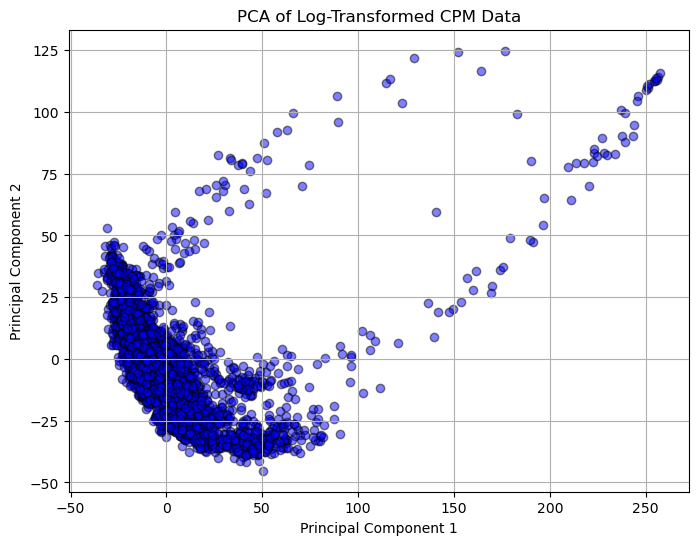

In [12]:
# Step 1: Standardize the data
scaler = StandardScaler()
log_cpm_scaled = scaler.fit_transform(log_cpm)  # Transpose so cells are rows

# Step 2: Perform PCA
pca = PCA(n_components=2)  # Take first two principal components

pca_result = pca.fit_transform(log_cpm_scaled)

# Step 3: Visualize the first two PCs

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c='blue', edgecolors='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Log-Transformed CPM Data")
plt.grid(True)

plt.show()

### Running the clustering in scanpy
* now we have our PCs, we can use these as features for clustering
* first we compute the nearest neighbours for each point, which allows the algorithm to know which datapoints are most similar to eachother
* doing this with the first n PCs allows us to remove noise and retain the most information about similarity between points

In [13]:
#Compute PCA
sc.pp.pca(adata, n_comps=5)  # Reduce dimensionality to 5 PCs

# Construct a k-nearest neighbor graph
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=5)

# Perform Leiden clustering
sc.tl.leiden(adata, resolution=1.0)  # Adjust resolution for granularity - < 1 = fewer larger clusters; > 1 more smaller clusters


2025-03-06 18:49:14.052201: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 18:49:14.284139: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 18:49:14.503850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741286954.762425     374 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741286954.837372     374 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 18:49:15.330433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Visualising the results of our clustering
* we want a way of seeing if our clusters make sense
* of course we cant visualise these higher dimensions
* UMAP is a non-linear dimensionality reduction technique, that aims to ensure that points that are nearby in high dimensions are nearby in lower dimensions
* doing this we can visualise our clusters

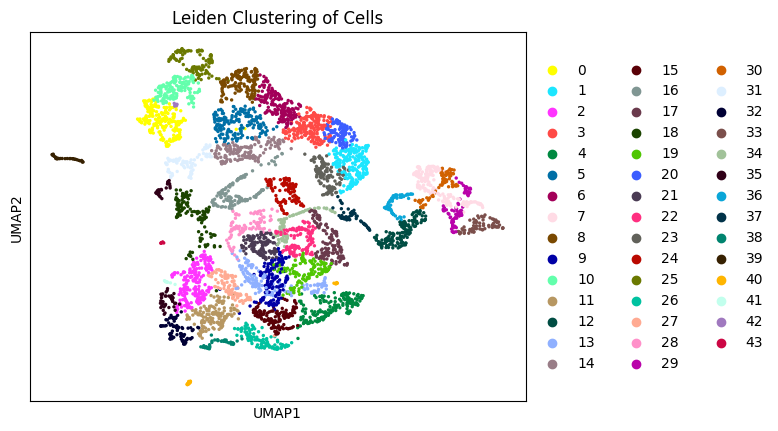

In [31]:
# Step 5: Compute UMAP for visualization
sc.tl.umap(adata)

# Step 6: Plot the clusters
sc.pl.umap(adata, color='leiden', title="Leiden Clustering of Cells")

# Clustering to identify celltypes
* we can use known marker genes for celltypes in the brain to find out what our cells are

In [37]:
marker_genes = {
    "Parvalbumin interneurons": ["Pvalb", "Erbb4", "Kcns3"],
    "Somatostatin interneurons": ["Sst", "Chodl", "Lhx6", "Lamp5"],
    "Vasoactive intestinal peptide (VIP) interneurons": ["Vip", "Htr3a", "Cck"],
    "Reelin-expressing interneurons": ["Reln", "Ndnf", "Lhx6"],
    "Layer 5/6 pyramidal neurons": ["Fezf2", "Ctip2", "Bcl11b", "Tbr1"],
    "Layer 2/3 pyramidal neurons": ["Satb2", "Cux2", "Lamp5"],
    "Oligodendrocytes": ["Mbp", "Plp1", "Olig2", "Sox10"],
    "Oligodendrocyte precursor cells (OPCs)": ["Pdgfra", "Cspg4", "Ng2", "Sox10"],
    "Astrocytes": ["Gfap", "Slc1a2", "Aqp4", "Aldh1l1"],
    "Microglia": ["C1qa", "C1qb", "C1qc", "P2ry12", "Tmem119", "Cx3cr1"],
    "Endothelial cells": ["Cldn5", "Pecam1", "Cd31", "Flt1"]
}


In [49]:
#score genes function finds the average expression of that set - mean expression of random genes
# it tells us to what extent this set of genes is expressed in each cell
for cell_type, genes in marker_genes.items():
    sc.tl.score_genes(adata, gene_list=genes, score_name=f"{cell_type}_score")

In [52]:
score_matrix.shape

(5028, 11)

In [53]:
#Assign celltype labels based on marker expression

# Extract all computed cell type scores
score_matrix = adata.obs[[f"{ct}_score" for ct in marker_genes.keys()]].values

score_matrix.shape

(5028, 11)

In [54]:
#visualise score matrix
score_matrix

array([[-0.40148636,  0.10662331,  1.54431004, ...,  1.29471871,
        -0.06890237,  0.        ],
       [-0.10437483, -0.01303057,  1.22053766, ..., -0.49052172,
        -0.23348907,  0.        ],
       [-0.05251831,  2.10237915,  1.41139743, ..., -0.02247195,
         0.        ,  0.        ],
       ...,
       [-0.76507388, -1.02210417, -1.71304984, ...,  0.09351425,
         1.47746321, -0.20199898],
       [-0.24690063, -1.11322131, -1.66622612, ...,  0.13384963,
        -0.01105306,  0.        ],
       [-0.63100861, -1.15964924, -1.87609617, ..., -0.29821081,
        -0.2674475 , -0.19657796]])

In [56]:
#compute the index of the largest value for each cell,i.e. for each row which cell has the highest score
index = np.argmax(score_matrix, axis=1)

In [57]:
#Assign celltype labels based on marker expression

# Extract all computed cell type scores
score_matrix = adata.obs[[f"{ct}_score" for ct in marker_genes.keys()]].values

# Assign the cell type with the highest score
adata.obs["predicted_celltype"] = np.array(list(marker_genes.keys()))[np.argmax(score_matrix, axis=1)]

# Check cell type distribution
adata.obs["predicted_celltype"].value_counts()

,count
predicted_celltype,
Layer 5/6 pyramidal neurons,1871
Layer 2/3 pyramidal neurons,1108
Vasoactive intestinal peptide (VIP) interneurons,526
Astrocytes,423
Parvalbumin interneurons,369
Reelin-expressing interneurons,199
Oligodendrocytes,191
Microglia,151
Somatostatin interneurons,77


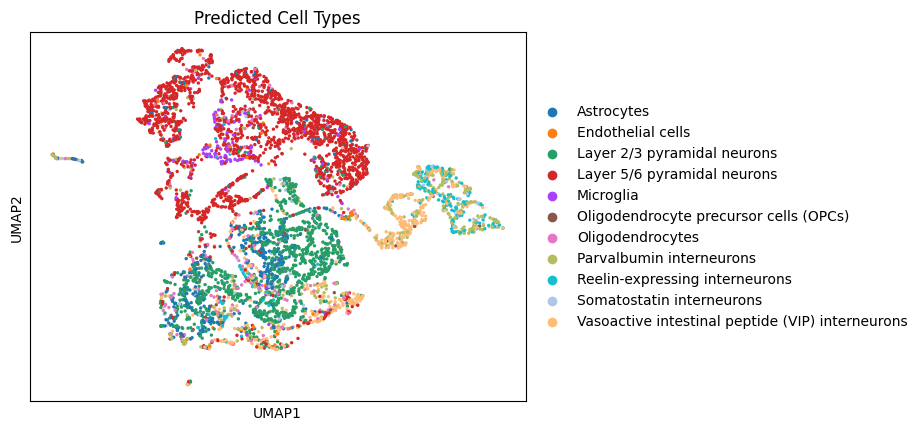

In [40]:
sc.pl.umap(adata, color="predicted_celltype", title="Predicted Cell Types")